In [1]:
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
import os
import subprocess
from pyspark.sql import SparkSession

runLocal = True

if runLocal:
    spark  = SparkSession.builder.master('local').appName('minst').getOrCreate()
else:
    p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('Spark Try') \
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

In [43]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import seaborn
import sklearn.decomposition
import scipy.linalg
%matplotlib inline

import pyspark.sql.functions
import pyspark.mllib.clustering

import re
import functools

In [44]:
df = spark.read.json('/project/cmsc25025/mnist/data.json')

In [45]:
df = df.sample(False, 1e-2, seed=123)

# Part 1: PCA

## Section a

In [46]:
def reg(x):
    v = np.array(x['features'])
    return (v - v.mean()) / v.std()

regged = df.rdd.map(reg).cache()

In [47]:
pcaComps = 10

def pca(rd, numComponents):
    U, D, V = scipy.linalg.svd(np.stack(rd.collect()))
    #It looks liek they are already sorted by scipy
    #but the docs don't mention it and sorting is cheap
    Dsort = D.argsort()
    return V[Dsort][:-numComponents - 1:-1], D[Dsort][:-numComponents - 1:-1]

def testPCA(rd, numComponents):
    B = np.stack(rd.collect(), axis = 1)
    clf = sklearn.decomposition.PCA(numComponents)
    #This produces a differently shape matrix than my method
    return clf.fit_transform(B)

def plotVecs(mat, matTest):
    figSize = 3
    n = mat.shape[0]
    fig, axes = plt.subplots(ncols = 2,
                             nrows=n,
                             figsize = (figSize * 2, figSize * n))
    
    for i in range(n):
        vec1 = mat[i, :]
        vec2 = matTest[:, i]
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]
        ax1.axis('off')
        ax1.set_title('${}^{{th}}$ PCA component'.format(i + 1))
        hmap = ax1.pcolor(vec1.reshape(28,28))
        ax2.axis('off')
        ax2.set_title('${}^{{th}}$ PCA component Test'.format(i + 1))
        hmap = ax2.pcolor(vec2.reshape(28,28))
    
    fig.tight_layout()
    #matplotlib bug
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Section a: First {} PCA components comparison".format(n), fontsize=20)
    plt.show()
    plt.close()

pcaMat, variance = pca(regged, pcaComps)
pcaTest = testPCA(regged, pcaComps)

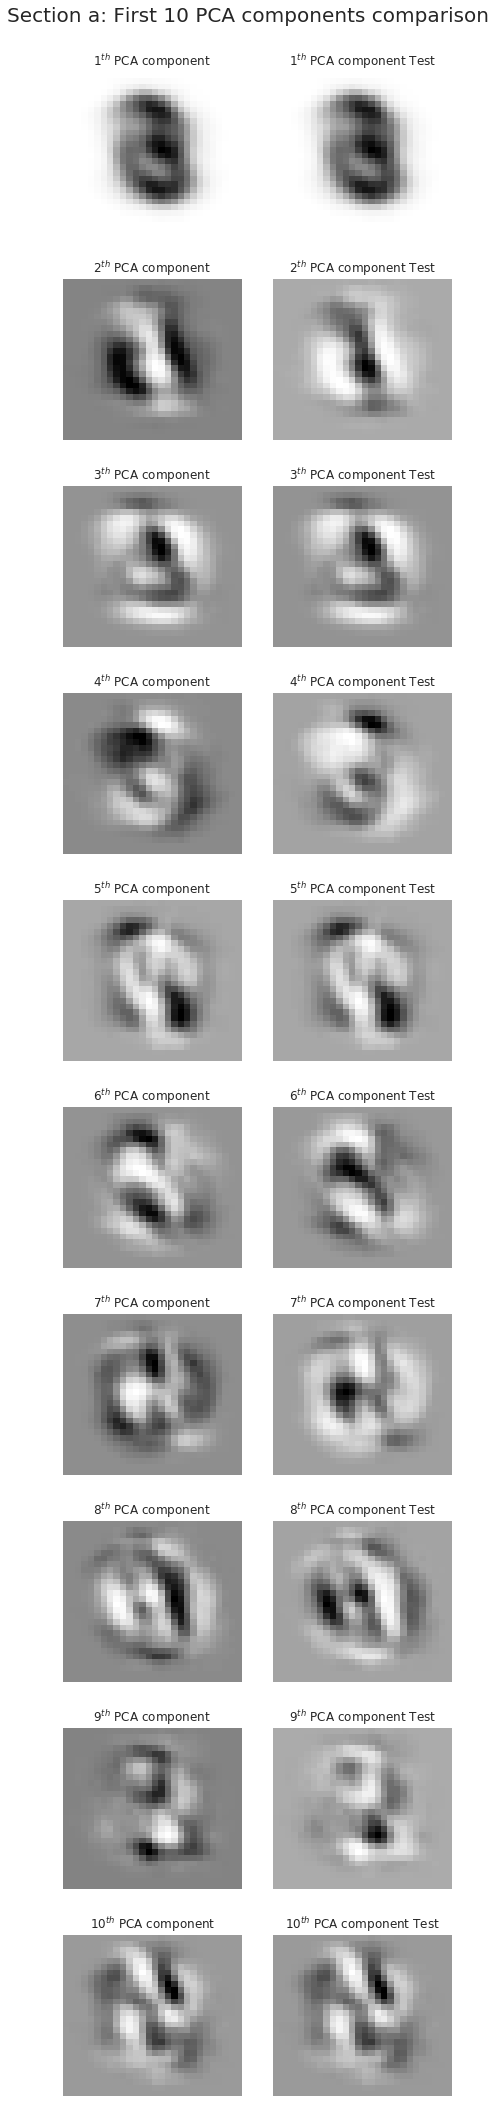

In [48]:
plotVecs(pcaMat, pcaTest)

## Section b

In [49]:
def secB(variance):
    figSize = 6
    fig, ax = plt.subplots(figsize = (figSize * 2, figSize))
    ax.plot(variance)
    ax.set_title("Section b: Sample Variance vs PCA Component Number", fontsize = 20)
    ax.set_xlabel('Sample Variance')
    ax.set_ylabel("PCA Component Number")
    plt.show()
    plt.close()
    #ax.set_xscale("log")

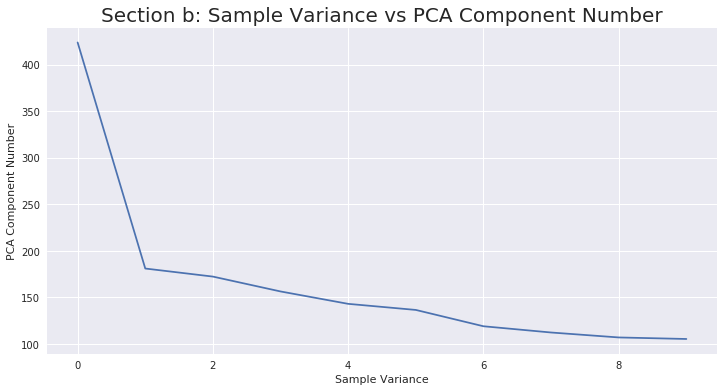

In [50]:
secB(variance)

## Section c

In [51]:
def reconLoss(intial, final):
    delta = intial - final
    return np.sum(delta * delta)

def secC(regged, mVals, perM):
    figSize = 2
    n = len(mVals) * perM
    fig, axes = plt.subplots(ncols = perM * 2,
                             nrows=len(mVals),
                             figsize = (figSize * perM * 2, figSize * len(mVals)))
    fig.suptitle("Section c: Dimension reduction effects", fontsize=20)
    points = regged.sample(False, 1, seed = 123).take(perM)
    maxPCA, variance = pca(regged, max(mVals))
    for i, m in enumerate(mVals):
        #Since PCA mat is sorted
        mat = maxPCA[:m]
        for j in range(perM):
            p = points[j]
            newP = mat.dot(p).dot(mat)
            ax1 = axes[i, 0 + j * 2]
            ax2 = axes[i, 1 + j * 2]
            ax1.set_title("Before $m = {}$, point {}".format(m , j + 1), fontsize=8)
            ax2.set_title("After, loss {:.2f}".format(reconLoss(p, newP)), fontsize=8)
            ax1.axis('off')
            ax2.axis('off')
            hmap = ax1.pcolor(p.reshape(28,28))
            hmap = ax2.pcolor(newP.reshape(28,28))
    plt.show()
    plt.close()

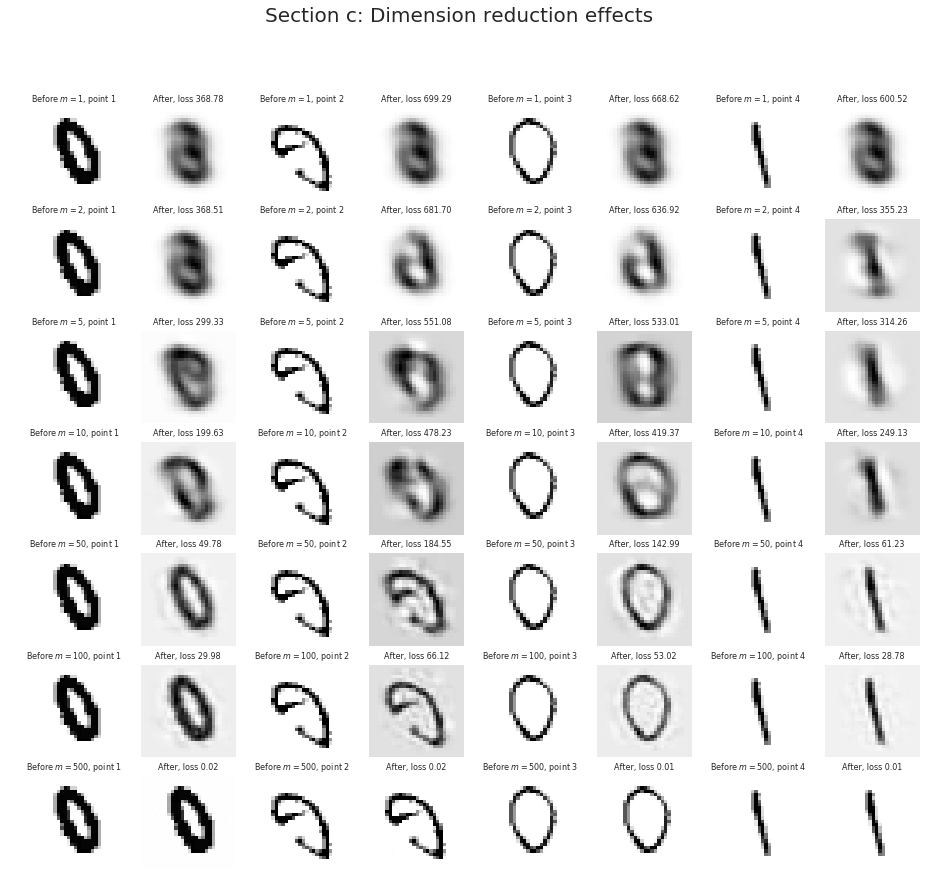

In [52]:
mVals = [1, 2, 5, 10, 50, 100, 500]

secC(regged, mVals, 4)

## Section d

In [53]:
def secD(regged, mVals):
    figSize = 6
    fig, ax = plt.subplots(figsize = (figSize * 2, figSize))
    losses = []
    maxPCA, variance = pca(regged, max(mVals))
    for m in mVals:
        mat = maxPCA[:m]
        reErrRDD = regged.map(lambda x: reconLoss(x, mat.dot(x).dot(mat)))
        losses.append(reErrRDD.mean())
    ax.plot(mVals, losses)
    ax.set_title("Section d: Reconstruction Error vs Number of PCA dimensions", fontsize = 20)
    ax.set_xlabel("Number of PCA dimensions")
    ax.set_ylabel("Reconstruction Error")
    #ax.set_xscale("log")

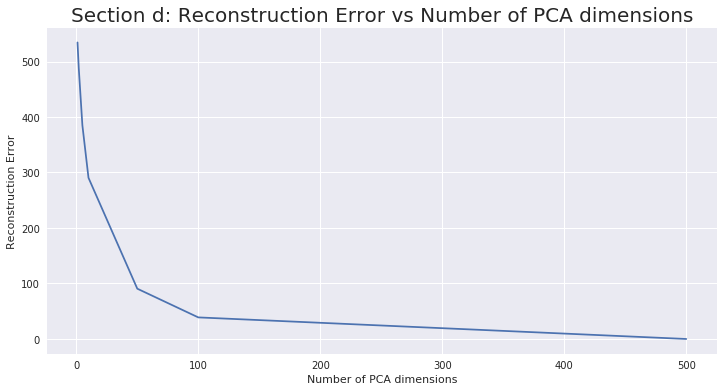

In [54]:
secD(regged, mVals)

# Part 2

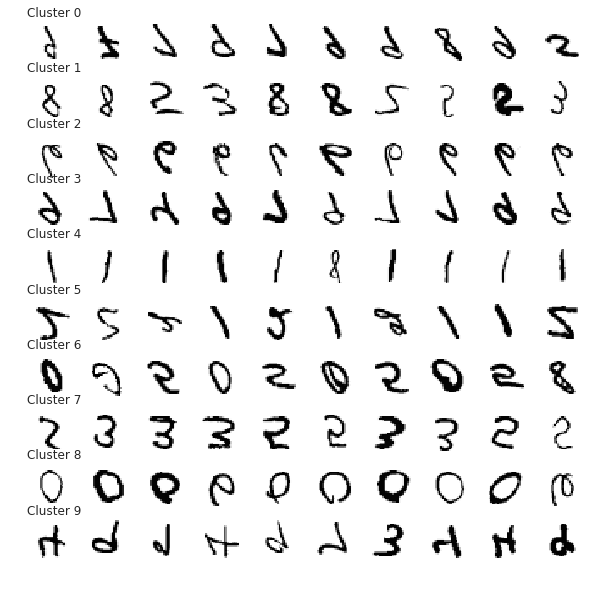

In [61]:
def part2(regged, perCluster):
    clusters = pyspark.mllib.clustering.KMeans.train(regged,
                                                     10,
                                                     maxIterations=50,
                                                     initializationMode="random")
    samplePoints = {i : [] for i in range(10)}
    points = regged.sample(False, 1, seed = 1234).take(1000)
    #Bogosort is best sort
    for p in points:
        if len([s for s in samplePoints.values() if len(s) < perCluster]) <= 0:
            break
        pred = clusters.predict(p)
        if len(samplePoints[pred]) < perCluster:
            samplePoints[pred].append(p)
    figSize = 1
    fig, axes = plt.subplots(ncols = perCluster,
                             nrows = 10,
                             figsize = (figSize * perCluster, figSize * 10))
    for k, selectedPoints in samplePoints.items():
        for i, point in enumerate(selectedPoints):
            ax = axes[k, i]
            hmap = ax.pcolor(point.reshape(28,28))
            ax.axis('off')
        axes[k, 0].set_title("Cluster {}".format(k), loc = 'left')
    return samplePoints
d = part2(regged, 10)